# IoT Digital Twin Anomaly Detection: Exploratory Analysis and Classical/Deep Learning Models
This notebook investigates an intrusion detection problem using an IoT digital twin dataset collected from an IP camera. The main objectives are to perform exploratory data analysis (EDA), engineer informative temporal and categorical features, and develop both classical machine learning and deep learning models to detect attacks and classify attack types. The analysis focuses on two prediction tasks: a binary classification of normal versus attack traffic, and a multi-class classification of attack_type, with particular attention to model performance and suitability for CPU-only deployment.


This notebook investigates an intrusion detection problem using an IoT digital twin dataset collected from an IP camera. The main objectives are to perform exploratory data analysis (EDA), engineer informative temporal and categorical features, and develop both classical machine learning and deep learning models to detect attacks and classify attack types. The analysis focuses on two prediction tasks: a binary classification of normal versus attack traffic, and a multi-class classification of attack_type, with particular attention to model performance and suitability for CPU-only deployment.


In [243]:
import os
import glob
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pprint as pp
import time
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.feature_selection import mutual_info_regression
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import pytz
from datetime import datetime, timezone

## Data Loading and Preprocessing

The dataset is loaded from the labeled IoT digital twin IP camera CSV file, using the original timestamp index as the primary temporal reference. The index is reset into an explicit `ts` column, converted to a proper datetime type, and the rows are sorted chronologically to preserve the true temporal order of traffic events. These steps ensure that subsequent resampling, rolling computations, and time-series visualizations operate on a consistent, well-ordered time axis.


In [245]:
df = pd.read_csv('C:/Users/lenovo/Downloads/iot_labeled_digitalipcam.csv', index_col=0)

In [246]:
df = df.reset_index().rename(columns={"index": "ts"})
df["ts"] = pd.to_datetime(df["ts"])
df = df.sort_values("ts")

In [247]:
df["attack_type_full"] = df["attack_type"].fillna("normal")


In [248]:
df = df.drop(columns=["bitrate_kbps", "frame_count"])

In [249]:
df.head()

,ts,fps,resolution,codec,label,attack_type,attack_type_full
1308,2025-06-07 01:22:21,0,unknown,unknown,1,ddos,ddos
1309,2025-06-07 01:22:23,15,704x576,h264,1,ddos,ddos
1310,2025-06-07 01:22:24,15,704x576,h264,1,ddos,ddos
1311,2025-06-07 01:22:25,15,704x576,h264,1,ddos,ddos
1312,2025-06-07 01:22:26,15,704x576,h264,1,ddos,ddos


In [250]:
df.shape

(20869, 7)

In [251]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20869 entries, 1308 to 20836
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ts                20869 non-null  datetime64[ns]
 1   fps               20869 non-null  int64         
 2   resolution        20869 non-null  object        
 3   codec             20869 non-null  object        
 4   label             20869 non-null  int64         
 5   attack_type       20869 non-null  object        
 6   attack_type_full  20869 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 1.3+ MB


In [252]:
df.describe()


,ts,fps,label
count,20869,20869.000000,20869.000000
mean,2025-06-10 19:53:29.053236992,14.948967,0.564522
min,2025-06-07 01:22:21,0.000000,0.000000
25%,2025-06-10 21:11:58,15.000000,0.000000
50%,2025-06-11 11:44:47,15.000000,1.000000
75%,2025-06-11 18:20:28,15.000000,1.000000
max,2025-06-11 23:53:20,15.000000,1.000000
std,NaN,0.873454,0.495831


## Target Construction

In addition to the binary `label` column that distinguishes normal from attack traffic, a composite multi-class target `attack_type_full` is constructed by filling missing `attack_type` values with the category "normal." This unified label enables simultaneous modeling of the presence of an attack and the specific attack category within a single framework. The resulting targets support both a traditional intrusion detection setting and a more fine-grained attack characterization task.


In [254]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# df already loaded, indexed by ts

numeric_features = ["fps"]
categorical_features = ["resolution", "codec"]

df["attack_type_full"] = df["attack_type"].fillna("normal")

X = df[numeric_features + categorical_features]
y_binary = df["label"]
y_multi = df["attack_type_full"]

X_train, X_test, yb_train, yb_test, ym_train, ym_test = train_test_split(
    X, y_binary, y_multi, test_size=0.2, shuffle=True, stratify=y_multi, random_state=42
)

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)


## Exploratory Data Analysis

The EDA section examines distributions of `label` and `attack_type_full`, as well as the marginal behavior of key numeric variables such as `fps` and . Time-series plots of normal and attack counts per minute, together with attack-type timelines, highlight when different attacks occur and how they evolve over the collection period. Additional visualizations of numeric features conditioned on the label reveal how attacks affect traffic characteristics, while correlation analyses provide insight into which features are most informative for classification.


In [256]:
df["label"].value_counts(normalize=True)

label
1    0.564522
0    0.435478
Name: proportion, dtype: float64

In [257]:
df["attack_type"].value_counts(dropna=False)

attack_type
normal      9088
password    4088
ddos        3204
mqtt        2867
scanning    1227
rtsp         395
Name: count, dtype: int64

In [258]:
# 1) if the index already looks like timestamps, convert index directly
df.index = pd.to_datetime(df.index)

# 2) move it to a single ts column, making sure no duplicate name
df = df.reset_index()              # column is now named whatever the index was
df = df.rename(columns={df.columns[0]: "ts"})  # force name to 'ts'

# 3) guarantee there is only ONE 'ts' column
df = df.loc[:, ~df.columns.duplicated()]

# 4) ts is already datetime from step 1, but this is safe and cheap
df["ts"] = pd.to_datetime(df["ts"])

df = df.sort_values("ts")



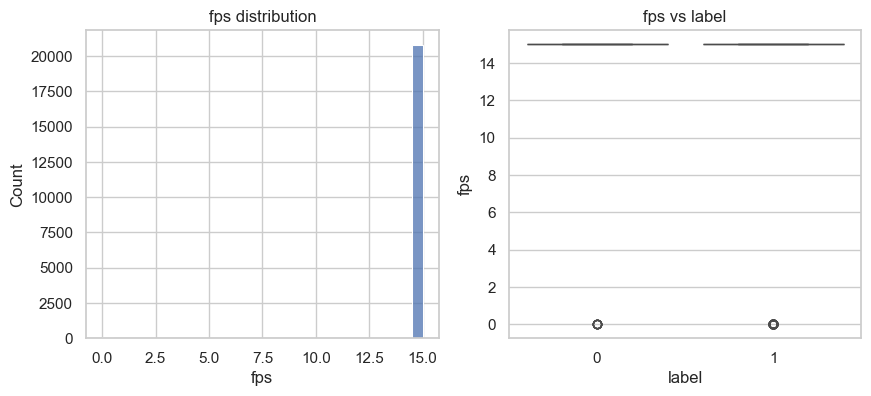

In [259]:
import seaborn as sns
import matplotlib.pyplot as plt

num_cols = ["fps"]

for col in num_cols:
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    sns.histplot(df[col], bins=30, ax=axes[0], kde=False)
    axes[0].set_title(f"{col} distribution")

    sns.boxplot(data=df, x="label", y=col, ax=axes[1])
    axes[1].set_title(f"{col} vs label")
    plt.show()


resolution
704x576    0.996598
unknown    0.003402
Name: proportion, dtype: float64


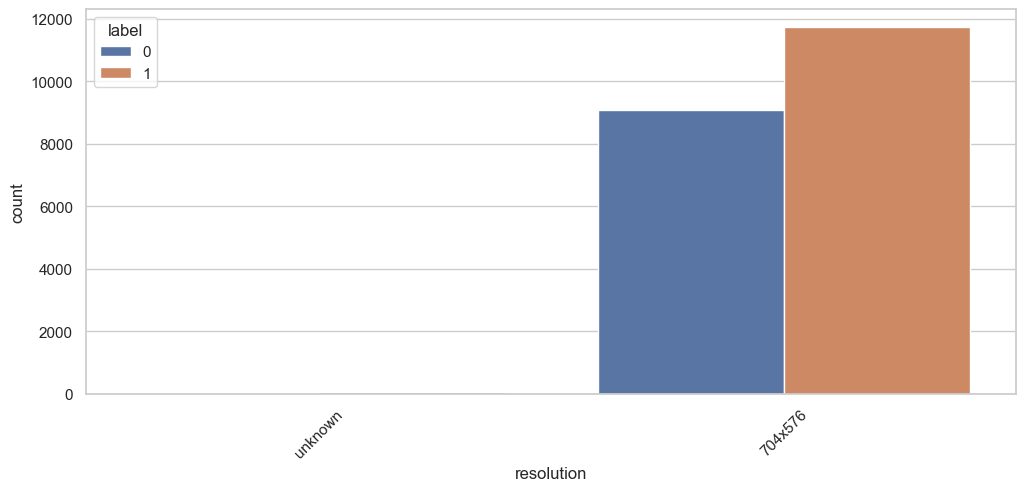

codec
h264       0.996598
unknown    0.003402
Name: proportion, dtype: float64


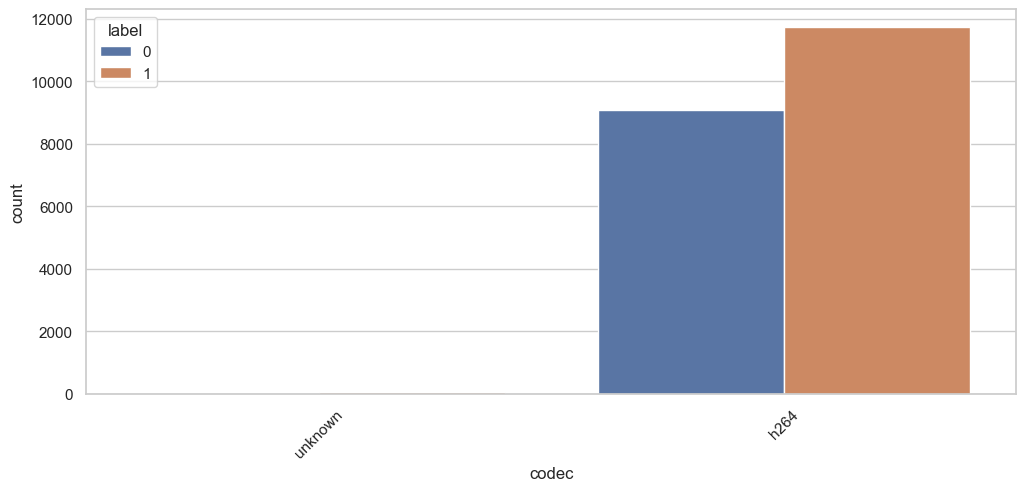

In [260]:
for col in ["resolution", "codec"]:
    print(df[col].value_counts(dropna=False, normalize=True).head(10))
    sns.countplot(data=df, x=col, hue="label")
    plt.xticks(rotation=45)
    plt.show()


label    1.000000
fps     -0.039699
Name: label, dtype: float64


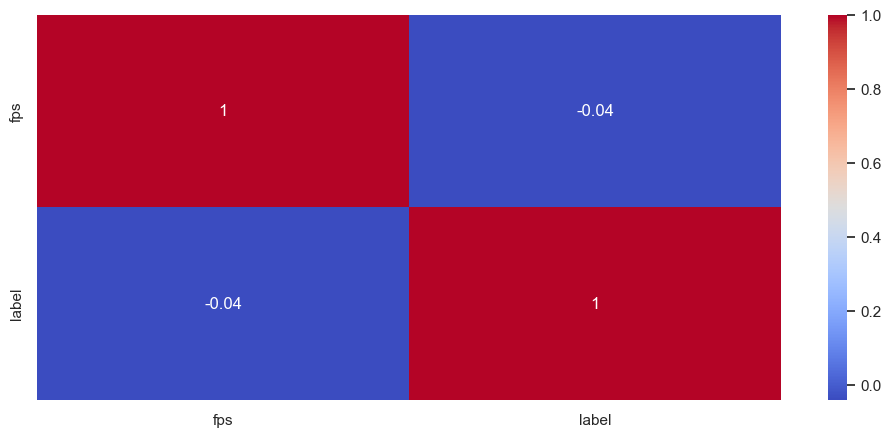

In [261]:
corr = df[num_cols + ["label"]].corr()
print(corr["label"].sort_values(ascending=False))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.show()


In [262]:
df.groupby("attack_type")[num_cols].mean()


,fps
attack_type,
ddos,14.831461
mqtt,14.968608
normal,14.988446
password,14.981654
rtsp,14.696203
scanning,14.889976


In [264]:
df = df.sort_values("ts")

window = "10S"

for col in ["fps"]:
    df[f"{col}_roll_mean"] = df[col].rolling(window=10, min_periods=1).mean()
    df[f"{col}_roll_std"] = df[col].rolling(window=10, min_periods=1).std().fillna(0)
    df[f"{col}_diff"] = df[col].diff().fillna(0)

df["inter_arrival"] = df["ts"].diff().dt.total_seconds().fillna(0)


In [265]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 5)

# Ensure ts is a proper datetime column
df["ts"] = pd.to_datetime(df["ts"])
df = df.sort_values("ts")

display(df.head())
display(df.describe(include="all"))

print("Label distribution:")
display(df["label"].value_counts(normalize=True))

print("Attack type distribution (including NaN):")
display(df["attack_type"].value_counts(dropna=False))


,ts,fps,resolution,codec,label,attack_type,attack_type_full,fps_roll_mean,fps_roll_std,fps_diff,inter_arrival
17779,1970-01-01 00:00:00.000000000,0,unknown,unknown,1,ddos,ddos,0.0,0.000000,0.0,0.000000e+00
17780,1970-01-01 00:00:00.000000001,0,unknown,unknown,1,ddos,ddos,0.0,0.000000,0.0,1.000000e-09
17781,1970-01-01 00:00:00.000000002,15,704x576,h264,1,ddos,ddos,5.0,8.660254,15.0,1.000000e-09
17782,1970-01-01 00:00:00.000000003,15,704x576,h264,1,ddos,ddos,7.5,8.660254,0.0,1.000000e-09
17783,1970-01-01 00:00:00.000000004,15,704x576,h264,1,ddos,ddos,9.0,8.215838,0.0,1.000000e-09


,ts,fps,resolution,codec,label,attack_type,attack_type_full,fps_roll_mean,fps_roll_std,fps_diff,inter_arrival
count,20869,20869.000000,20869,20869,20869.000000,20869,20869,20869.000000,20869.000000,20869.000000,2.086900e+04
unique,NaN,NaN,2,2,NaN,6,6,NaN,NaN,NaN,NaN
top,NaN,NaN,704x576,h264,NaN,normal,normal,NaN,NaN,NaN,NaN
freq,NaN,NaN,20798,20798,NaN,9088,9088,NaN,NaN,NaN,NaN
mean,1970-01-01 00:00:00.000010434,14.948967,NaN,NaN,0.564522,NaN,NaN,14.946841,0.102119,0.000719,9.999521e-10
min,1970-01-01 00:00:00,0.000000,NaN,NaN,0.000000,NaN,NaN,0.000000,0.000000,-15.000000,0.000000e+00
25%,1970-01-01 00:00:00.000005217,15.000000,NaN,NaN,0.000000,NaN,NaN,15.000000,0.000000,0.000000,1.000000e-09
50%,1970-01-01 00:00:00.000010434,15.000000,NaN,NaN,1.000000,NaN,NaN,15.000000,0.000000,0.000000,1.000000e-09
75%,1970-01-01 00:00:00.000015651,15.000000,NaN,NaN,1.000000,NaN,NaN,15.000000,0.000000,0.000000,1.000000e-09
max,1970-01-01 00:00:00.000020868,15.000000,NaN,NaN,1.000000,NaN,NaN,15.000000,8.660254,15.000000,1.000000e-09


Label distribution:


label
1    0.564522
0    0.435478
Name: proportion, dtype: float64

Attack type distribution (including NaN):


attack_type
normal      9088
password    4088
ddos        3204
mqtt        2867
scanning    1227
rtsp         395
Name: count, dtype: int64

ts dtype: datetime64[ns]
ts min/max: 2025-06-07 01:22:21 -> 2025-06-11 23:53:20

Head with ts, label, attack_type:
                      ts  label attack_type
1308 2025-06-07 01:22:21      1        ddos
1309 2025-06-07 01:22:23      1        ddos
1310 2025-06-07 01:22:24      1        ddos
1311 2025-06-07 01:22:25      1        ddos
1312 2025-06-07 01:22:26      1        ddos

Label value counts:
label
1    11781
0     9088
Name: count, dtype: int64

Resampled label_time head:
label                0   1
ts                        
2025-06-07 01:22:00  0  33
2025-06-07 01:23:00  0  53
2025-06-07 01:24:00  0  52
2025-06-07 01:25:00  0  48
2025-06-07 01:26:00  0  53

Resampled label_time tail:
label                0   1
ts                        
2025-06-11 23:47:00  0   7
2025-06-11 23:49:00  0  17
2025-06-11 23:50:00  0  36
2025-06-11 23:52:00  0  29
2025-06-11 23:53:00  0  18


C:\Users\lenovo\AppData\Local\Temp\ipykernel_11568\2982642078.py:25: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df.resample("1T", on="ts")["label"].value_counts().unstack(fill_value=0)


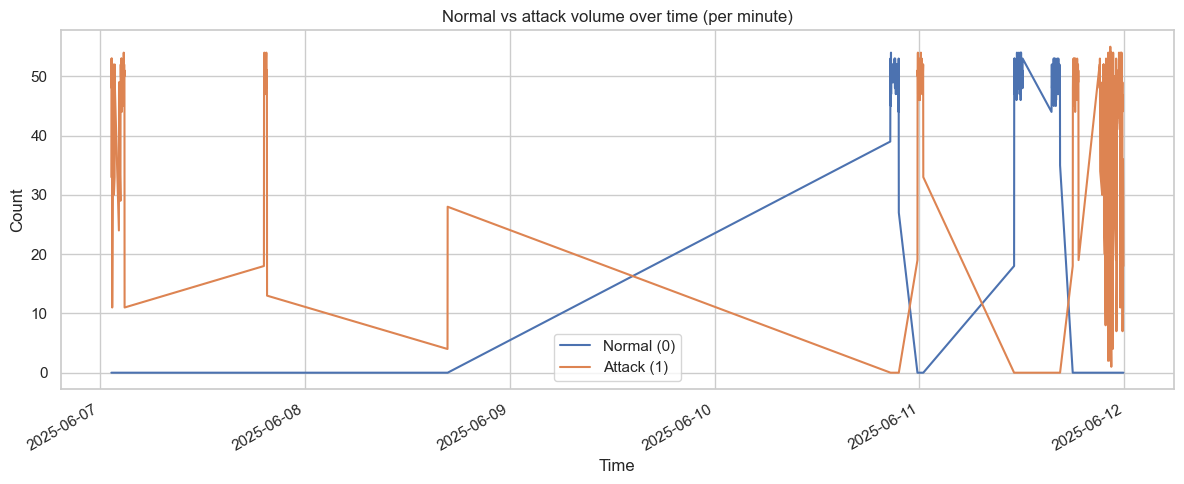

In [266]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Load and fix ts
df = pd.read_csv("C:/Users/lenovo/Downloads/iot_labeled_digitalipcam.csv", index_col=0)

# index is timestamps -> convert and move to 'ts' column
df.index = pd.to_datetime(df.index)
df = df.reset_index().rename(columns={df.columns[0]: "ts"})
df = df.loc[:, ~df.columns.duplicated()]  # safety: drop duplicate columns
df["ts"] = pd.to_datetime(df["ts"])
df = df.sort_values("ts")

# 2) Quick checks on ts and label
print("ts dtype:", df["ts"].dtype)
print("ts min/max:", df["ts"].min(), "->", df["ts"].max())
print("\nHead with ts, label, attack_type:")
print(df[["ts", "label", "attack_type"]].head())

print("\nLabel value counts:")
print(df["label"].value_counts())

# 3) Resample per minute
label_time = (
    df.resample("1T", on="ts")["label"].value_counts().unstack(fill_value=0)
)

print("\nResampled label_time head:")
print(label_time.head())
print("\nResampled label_time tail:")
print(label_time.tail())

# 4) Plot
ax = label_time.plot(figsize=(12, 5))
ax.set_title("Normal vs attack volume over time (per minute)")
ax.set_xlabel("Time")
ax.set_ylabel("Count")
ax.legend(["Normal (0)", "Attack (1)"])
plt.tight_layout()
plt.show()


C:\Users\lenovo\AppData\Local\Temp\ipykernel_11568\1934866044.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df.resample("1T", on="ts")["label"].value_counts().unstack(fill_value=0)



label_time head:
label                0   1
ts                        
2025-06-07 01:22:00  0  33
2025-06-07 01:23:00  0  53
2025-06-07 01:24:00  0  52
2025-06-07 01:25:00  0  48
2025-06-07 01:26:00  0  53


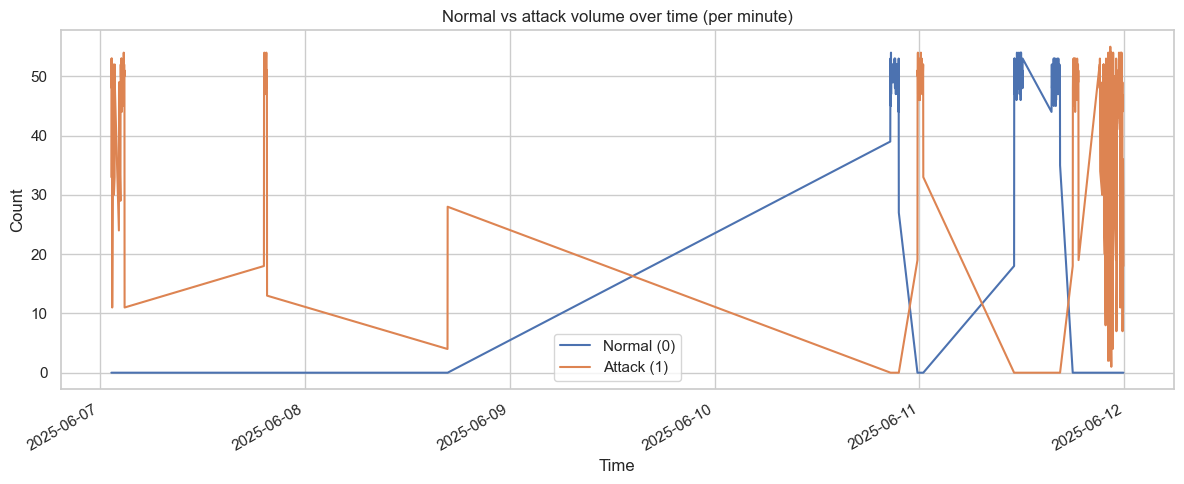

In [267]:
label_time = (
    df.resample("1T", on="ts")["label"].value_counts().unstack(fill_value=0)
)
print("\nlabel_time head:")
print(label_time.head())

ax = label_time.plot(figsize=(12, 5))
ax.set_title("Normal vs attack volume over time (per minute)")
ax.set_xlabel("Time")
ax.set_ylabel("Count")
ax.legend(["Normal (0)", "Attack (1)"])
plt.tight_layout()
plt.show()

In [268]:
series = df.resample("1T", on="ts")["label"].count()
series.name = "rows_per_minute"

print("\nDecomposition series head:")
print(series.head())



Decomposition series head:
ts
2025-06-07 01:22:00    33
2025-06-07 01:23:00    53
2025-06-07 01:24:00    52
2025-06-07 01:25:00    48
2025-06-07 01:26:00    53
Freq: min, Name: rows_per_minute, dtype: int64


C:\Users\lenovo\AppData\Local\Temp\ipykernel_11568\1498786495.py:1: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  series = df.resample("1T", on="ts")["label"].count()


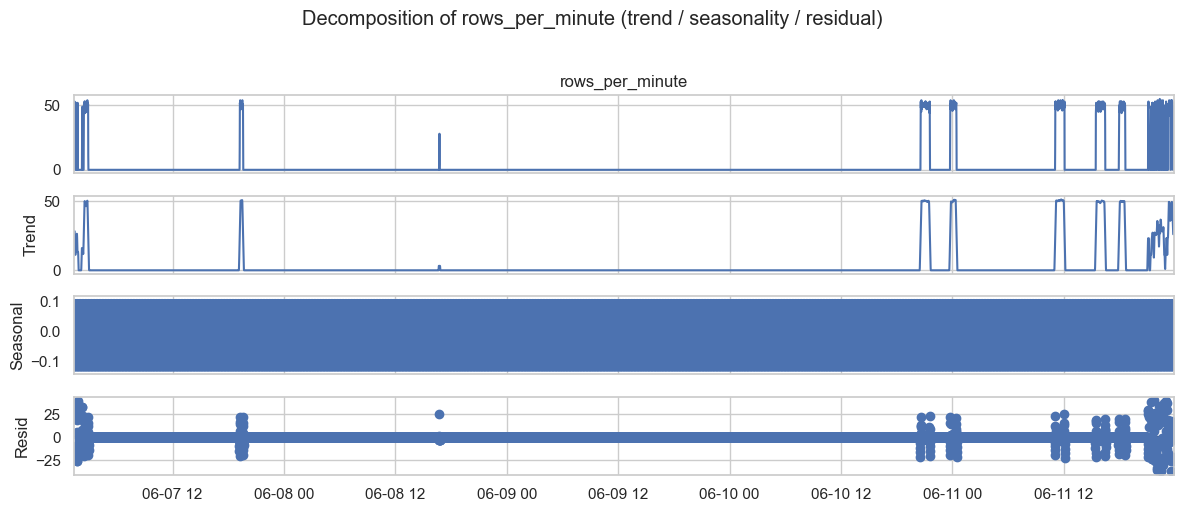

In [269]:
from statsmodels.tsa.seasonal import seasonal_decompose
# 5) Seasonal decomposition
result = seasonal_decompose(series, model="additive", period=10)  # adjust period if needed
result.plot()
plt.suptitle("Decomposition of rows_per_minute (trend / seasonality / residual)", y=1.02)
plt.tight_layout()
plt.show()

['ts', 'fps', 'resolution', 'codec', 'frame_count', 'label', 'attack_type']
Numeric columns used: ['fps']


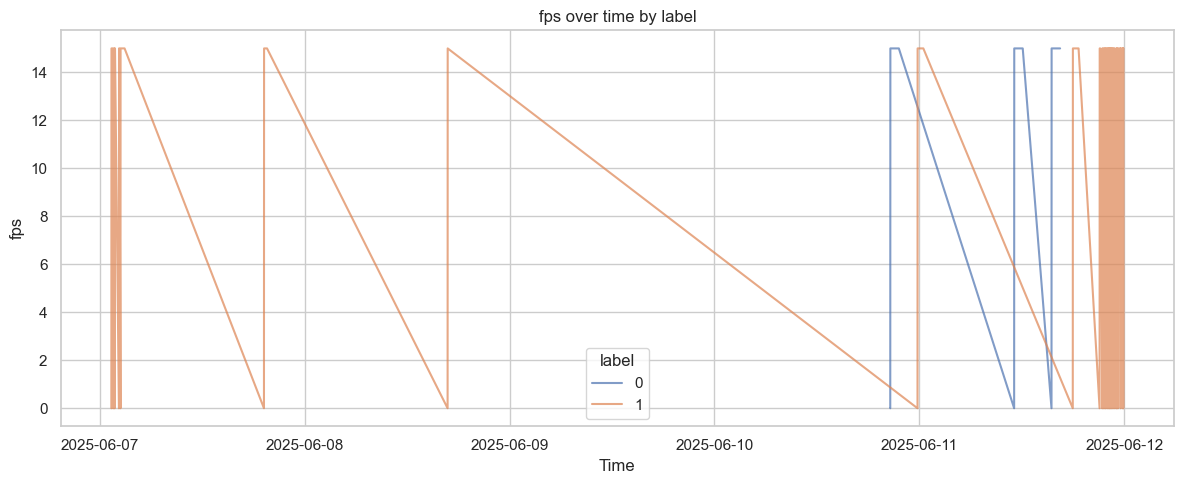

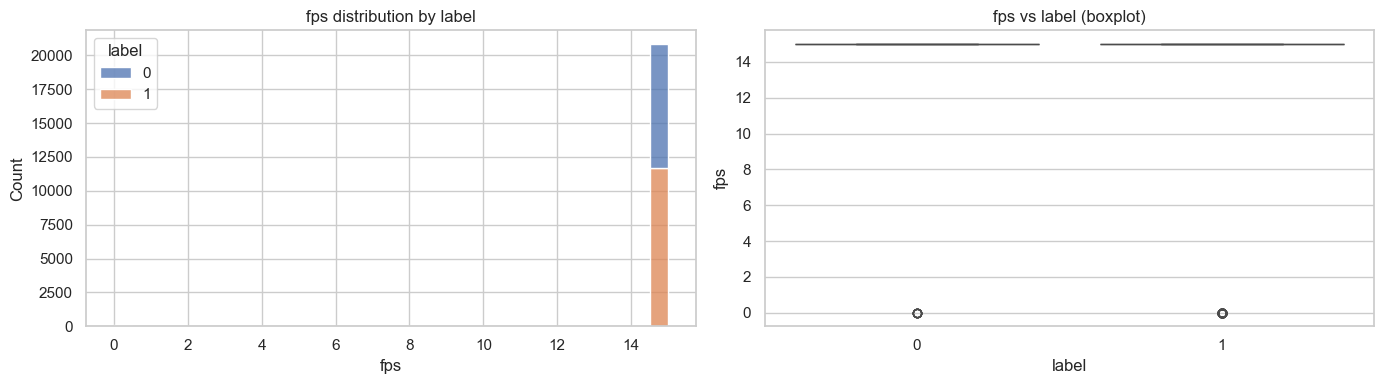

In [270]:
print(df.columns.tolist())

num_cols = ["fps"]

# keep only numeric columns that actually exist
num_cols = [c for c in num_cols if c in df.columns]
print("Numeric columns used:", num_cols)

for col in num_cols:
    # time vs label plot
    sns.lineplot(data=df, x="ts", y=col, hue="label", alpha=0.7)
    plt.title(f"{col} over time by label")
    plt.xlabel("Time")
    plt.ylabel(col)
    plt.legend(title="label")
    plt.tight_layout()
    plt.show()

    # distribution by label
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    sns.histplot(data=df, x=col, hue="label", bins=30, ax=axes[0], multiple="stack")
    axes[0].set_title(f"{col} distribution by label")

    sns.boxplot(data=df, x="label", y=col, ax=axes[1])
    axes[1].set_title(f"{col} vs label (boxplot)")
    plt.tight_layout()
    plt.show()


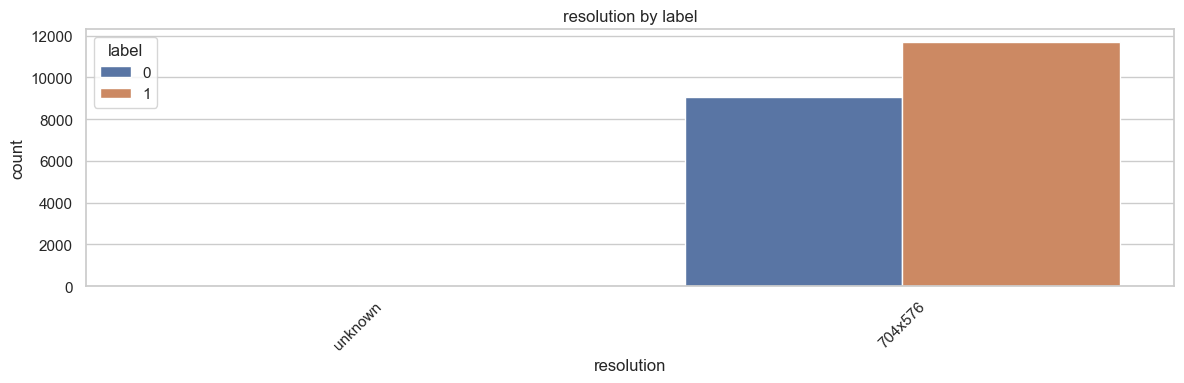

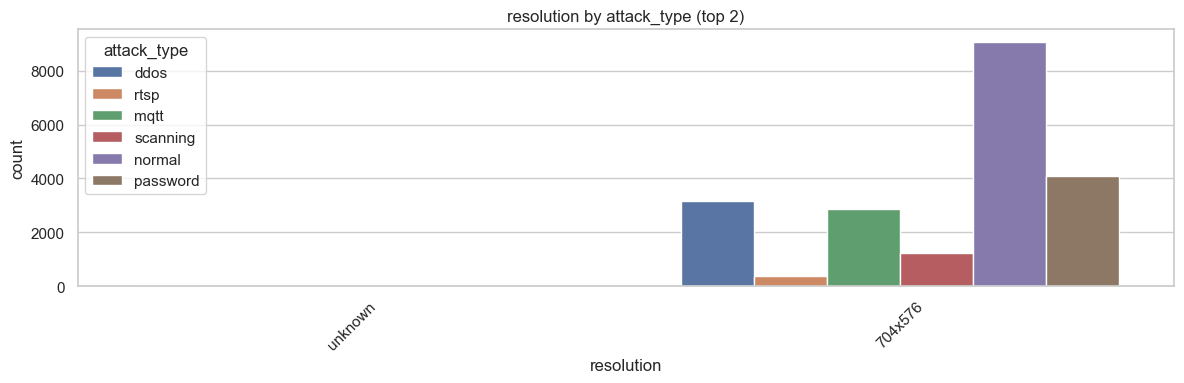

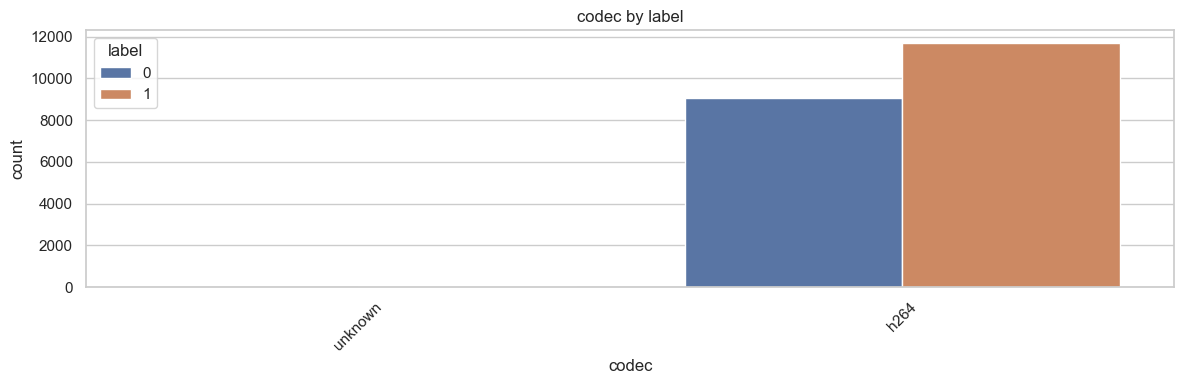

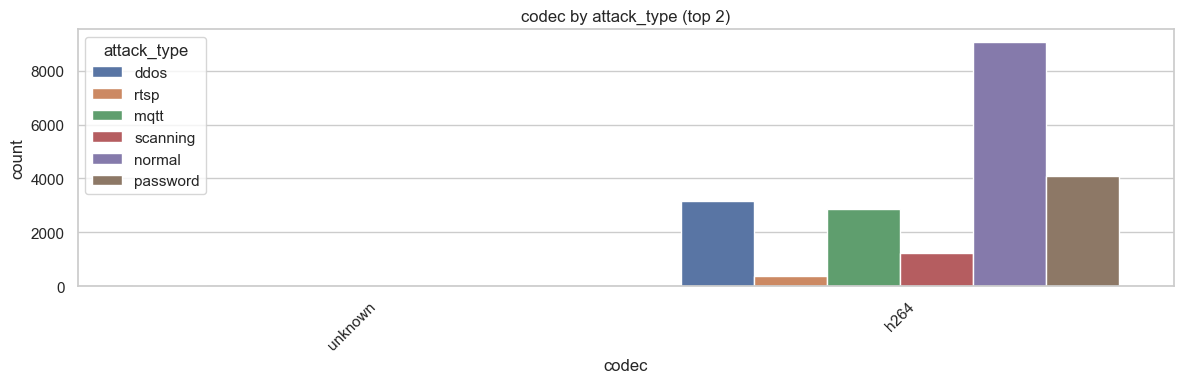

In [271]:
for col in ["resolution", "codec"]:
    plt.figure(figsize=(12, 4))
    sns.countplot(data=df, x=col, hue="label")
    plt.title(f"{col} by label")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # attack-type breakdown (top categories)
    top_vals = df[col].value_counts().head(6).index
    sub = df[df[col].isin(top_vals)]
    plt.figure(figsize=(12, 4))
    sns.countplot(data=sub, x=col, hue="attack_type")
    plt.title(f"{col} by attack_type (top {len(top_vals)})")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


Columns in df:
['ts', 'fps', 'resolution', 'codec', 'frame_count', 'label', 'attack_type']

Numeric columns used: ['fps']

Correlation matrix:
            fps     label
fps    1.000000 -0.039699
label -0.039699  1.000000


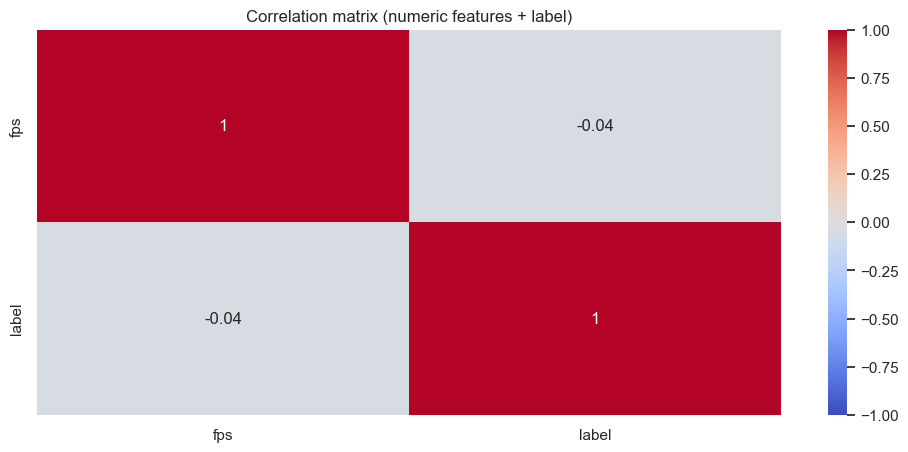


Per-attack-type mean profile:
                   fps
attack_type           
rtsp         14.696203
ddos         14.831461
scanning     14.889976
mqtt         14.968608
password     14.981654
normal       14.988446


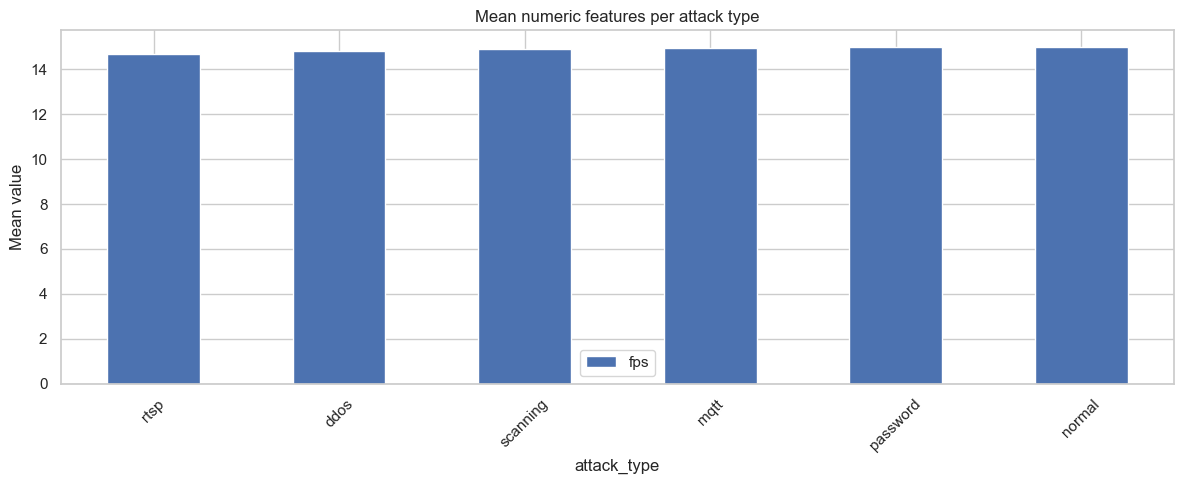

In [272]:
import seaborn as sns
import matplotlib.pyplot as plt

print("Columns in df:")
print(df.columns.tolist())

# define desired numeric columns, but keep only those that exist
desired_num = ["fps"]
num_cols = [c for c in desired_num if c in df.columns]
print("\nNumeric columns used:", num_cols)

# 1) Correlation with label
corr = df[num_cols + ["label"]].corr()
print("\nCorrelation matrix:")
print(corr)

sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation matrix (numeric features + label)")
plt.show()

# 2) Mean profile per attack type
if "attack_type" in df.columns:
    attack_profile = (
        df.groupby("attack_type")[num_cols].mean().sort_values(num_cols[0])
    )
    print("\nPer-attack-type mean profile:")
    print(attack_profile)

    attack_profile.plot(kind="bar")
    plt.title("Mean numeric features per attack type")
    plt.ylabel("Mean value")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("Column 'attack_type' not found in df.")


Columns in df: ['ts', 'fps', 'resolution', 'codec', 'frame_count', 'label', 'attack_type']
Using for rolling: ['fps']


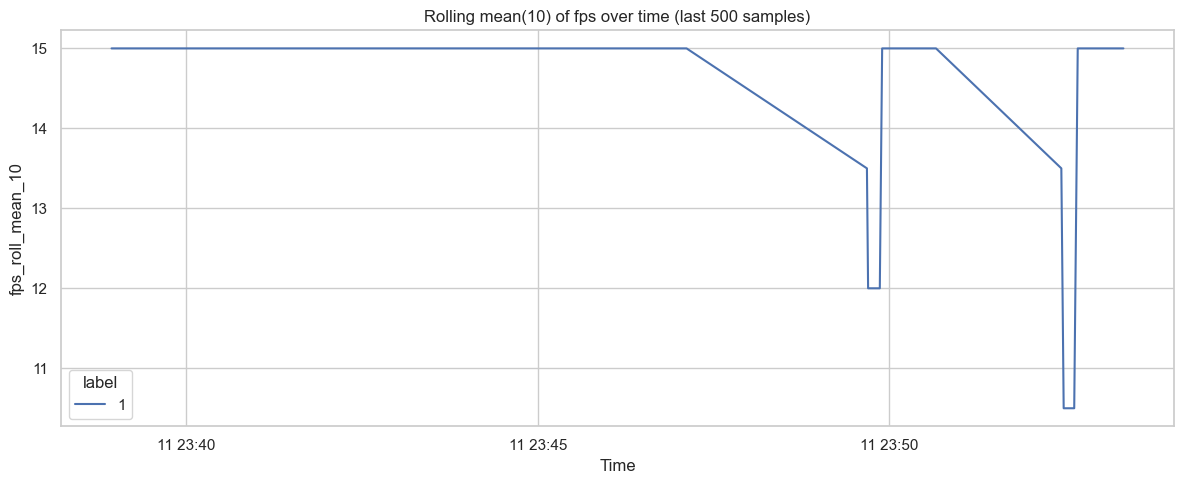

In [273]:
import seaborn as sns
import matplotlib.pyplot as plt

print("Columns in df:", df.columns.tolist())

df = df.sort_values("ts")

num_for_rolling = []
for col in ["fps"]:
    if col in df.columns:
        num_for_rolling.append(col)

print("Using for rolling:", num_for_rolling)

for col in num_for_rolling:
    roll_col = f"{col}_roll_mean_10"
    df[roll_col] = df[col].rolling(window=10, min_periods=1).mean()

    sns.lineplot(data=df.tail(500), x="ts", y=roll_col, hue="label")
    plt.title(f"Rolling mean(10) of {col} over time (last 500 samples)")
    plt.xlabel("Time")
    plt.ylabel(roll_col)
    plt.tight_layout()
    plt.show()


## Feature Engineering

The feature engineering section augments the original variables with several time-aware and statistical descriptors. These include absolute time features (`seconds_from_start`, `hour`, `minute`), rolling means and standard deviations over short windows, and first-order differences for core numeric signals such as `fps`. Categorical attributes, namely `resolution` and `codec`, are standardized by replacing missing or unknown values with explicit categories, preparing them for subsequent one-hot encoding. Together, these engineered features capture both instantaneous measurements and local temporal dynamics that are crucial for effective anomaly detection.


In [275]:
import pandas as pd
from sklearn.model_selection import train_test_split

# 1) Make sure ts is clean and sorted
df["ts"] = pd.to_datetime(df["ts"])
df = df.sort_values("ts")

# 2) Targets
df["attack_type_full"] = df["attack_type"].fillna("normal")

# 3) Time‑based features
df["seconds_from_start"] = (df["ts"] - df["ts"].min()).dt.total_seconds()
df["hour"] = df["ts"].dt.hour
df["minute"] = df["ts"].dt.minute

# 4) Rolling / change features (row‑based window)
num_cols = [c for c in ["fps"] if c in df.columns]

for col in num_cols:
    df[f"{col}_diff"] = df[col].diff().fillna(0)
    df[f"{col}_roll_mean_10"] = df[col].rolling(window=10, min_periods=1).mean()
    df[f"{col}_roll_std_10"] = df[col].rolling(window=10, min_periods=1).std().fillna(0)

# 5) Encoded categorical helpers
for col in ["resolution", "codec"]:
    if col in df.columns:
        df[col] = df[col].fillna("missing")

# 6) Final feature list for models
feature_cols = []

feature_cols += num_cols
feature_cols += [f"{c}_diff" for c in num_cols]
feature_cols += [f"{c}_roll_mean_10" for c in num_cols]
feature_cols += [f"{c}_roll_std_10" for c in num_cols]

feature_cols += [c for c in ["resolution", "codec"] if c in df.columns]
feature_cols += ["seconds_from_start", "hour", "minute"]

print("Number of features:", len(feature_cols))
print("Feature columns:", feature_cols[:20], "...")

X = df[feature_cols]
y_binary = df["label"]
y_multi = df["attack_type_full"]

X_train, X_test, yb_train, yb_test, ym_train, ym_test = train_test_split(
    X, y_binary, y_multi, test_size=0.2, shuffle=True, stratify=y_multi, random_state=42
)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


Number of features: 9
Feature columns: ['fps', 'fps_diff', 'fps_roll_mean_10', 'fps_roll_std_10', 'resolution', 'codec', 'seconds_from_start', 'hour', 'minute'] ...
X_train shape: (16695, 9)
X_test shape: (4174, 9)


## Classical Machine Learning Models

Classical machine learning models are trained on the engineered feature set using a scikit-learn `ColumnTransformer` to apply standardization to numeric features and one-hot encoding to categorical features within a unified pipeline. Logistic Regression provides a linear baseline, while Random Forest offers a non-linear ensemble capable of capturing more complex interactions between features. Model performance is evaluated on the binary label task using accuracy and macro F1, demonstrating that tree-based methods can almost perfectly separate normal and attack traffic in this representation.


In [277]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

num_cols = [c for c in X_train.columns if c.startswith(("fps")) or
            c.endswith(("_diff", "_roll_mean_10", "_roll_std_10")) or
            c in ["seconds_from_start", "hour", "minute"]]

cat_cols = [c for c in ["resolution", "codec"] if c in X_train.columns]

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ],
    remainder="drop",
)


In [278]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score
import time

def train_and_eval(model, X_tr, y_tr, X_te, y_te, task_name):
    pipe = Pipeline(steps=[("preprocess", preprocess), ("model", model)])
    start = time.time()
    pipe.fit(X_tr, y_tr)
    train_time = time.time() - start

    start = time.time()
    y_pred = pipe.predict(X_te)
    infer_time = (time.time() - start) / len(X_te)

    print(f"\n=== {task_name} | {model.__class__.__name__} ===")
    print("Train time (s):", round(train_time, 3))
    print("Avg inference time (ms/sample):", round(infer_time * 1000, 4))
    print("Accuracy:", round(accuracy_score(y_te, y_pred), 4))
    print("Macro F1:", round(f1_score(y_te, y_pred, average='macro'), 4))
    print(classification_report(y_te, y_pred))

    return pipe

# Binary label
log_bin = train_and_eval(
    LogisticRegression(max_iter=1000, n_jobs=-1),
    X_train, yb_train, X_test, yb_test, "Binary label"
)

rf_bin = train_and_eval(
    RandomForestClassifier(
        n_estimators=200, max_depth=None, n_jobs=-1, random_state=42
    ),
    X_train, yb_train, X_test, yb_test, "Binary label"
)

# Multi‑class attack_type_full
log_multi = train_and_eval(
    LogisticRegression(max_iter=1000, n_jobs=-1, multi_class="auto"),
    X_train, ym_train, X_test, ym_test, "Attack_type_full"
)

rf_multi = train_and_eval(
    RandomForestClassifier(
        n_estimators=300, max_depth=None, n_jobs=-1, random_state=42
    ),
    X_train, ym_train, X_test, ym_test, "Attack_type_full"
)



=== Binary label | LogisticRegression ===
Train time (s): 5.782
Avg inference time (ms/sample): 0.0019
Accuracy: 0.5364
Macro F1: 0.5313
              precision    recall  f1-score   support

           0       0.47      0.50      0.48      1818
           1       0.59      0.57      0.58      2356

    accuracy                           0.54      4174
   macro avg       0.53      0.53      0.53      4174
weighted avg       0.54      0.54      0.54      4174


=== Binary label | RandomForestClassifier ===
Train time (s): 0.599
Avg inference time (ms/sample): 0.016
Accuracy: 1.0
Macro F1: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1818
           1       1.00      1.00      1.00      2356

    accuracy                           1.00      4174
   macro avg       1.00      1.00      1.00      4174
weighted avg       1.00      1.00      1.00      4174



C:\Users\lenovo\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



=== Attack_type_full | LogisticRegression ===
Train time (s): 5.678
Avg inference time (ms/sample): 0.0012
Accuracy: 0.6162
Macro F1: 0.5246
              precision    recall  f1-score   support

        ddos       0.38      0.05      0.08       641
        mqtt       0.61      0.46      0.52       573
      normal       0.57      0.96      0.71      1818
    password       1.00      0.34      0.51       818
        rtsp       0.44      0.33      0.38        79
    scanning       0.98      0.92      0.95       245

    accuracy                           0.62      4174
   macro avg       0.66      0.51      0.52      4174
weighted avg       0.65      0.62      0.56      4174


=== Attack_type_full | RandomForestClassifier ===
Train time (s): 1.052
Avg inference time (ms/sample): 0.049
Accuracy: 1.0
Macro F1: 1.0
              precision    recall  f1-score   support

        ddos       1.00      1.00      1.00       641
        mqtt       1.00      1.00      1.00       573
      normal 

## Time-Series Behavior and ARIMA Analysis

To study the temporal dynamics of the system, the notebook aggregates the number of attack events per minute and treats this count as a univariate time series. An autoregressive integrated moving average (ARIMA) model is then estimated on a recent segment of the series, with its order selected via a constrained `auto_arima` search to balance expressiveness and computational efficiency. Forecast errors from the fitted ARIMA model are used to derive simple anomaly scores, allowing comparison between statistically unexpected traffic spikes and the ground-truth attack labels.


C:\Users\lenovo\AppData\Local\Temp\ipykernel_11568\3924243823.py:9: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .resample("1T", on="ts")["label"]
C:\Users\lenovo\AppData\Local\Temp\ipykernel_11568\3924243823.py:12: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  series = series.asfreq("T").fillna(0)


RMSE: 484.12113781718165


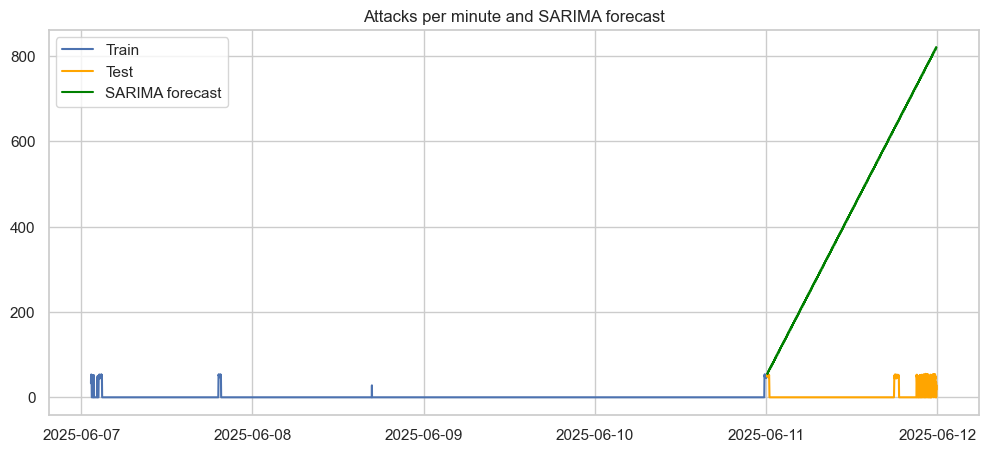

Number of anomaly timestamps: 0


In [280]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# 1) Build a univariate series (example: total attacks per minute)
series = (
    df[df["label"] == 1]
    .resample("1T", on="ts")["label"]
    .count()
)
series = series.asfreq("T").fillna(0)

# 2) Train/test split in time order
train_size = int(len(series) * 0.8)
train, test = series.iloc[:train_size], series.iloc[train_size:]

# 3) Fit SARIMA (p,d,q)(P,D,Q,s) – you can tune these later
model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,10))
res = model.fit(disp=False)

# 4) Forecast on test range
pred = res.predict(start=test.index[0], end=test.index[-1])

# 5) Evaluate and visualize
rmse = np.sqrt(mean_squared_error(test, pred))
print("RMSE:", rmse)

plt.figure(figsize=(12,5))
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Test", color="orange")
plt.plot(pred.index, pred, label="SARIMA forecast", color="green")
plt.legend()
plt.title("Attacks per minute and SARIMA forecast")
plt.show()

# 6) Simple anomaly score from forecast error
errors = (test - pred).abs()
threshold = errors.mean() + 3 * errors.std()
anomalies = errors[errors > threshold]

print("Number of anomaly timestamps:", len(anomalies))


Full series length: 7112
Series used for auto_arima: 2000
Searching ARIMA orders with auto_arima...
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12679.749, Time=0.04 sec


C:\Users\lenovo\AppData\Local\Temp\ipykernel_11568\2039352774.py:14: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .resample("1T", on="ts")["label"]
C:\Users\lenovo\AppData\Local\Temp\ipykernel_11568\2039352774.py:17: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  series = series.asfreq("T").fillna(0)


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12663.236, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12659.321, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12677.754, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.63 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=12652.394, Time=0.36 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=12474.756, Time=0.57 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=12382.908, Time=1.22 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=12426.548, Time=0.84 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=12380.923, Time=0.53 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=12472.836, Time=0.21 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=12424.605, Time=0.33 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=12564.409, Time=0.38 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 5.484 seconds

Best ARIMA order: (2, 1, 2)
Test RMSE: 50.23531673143412


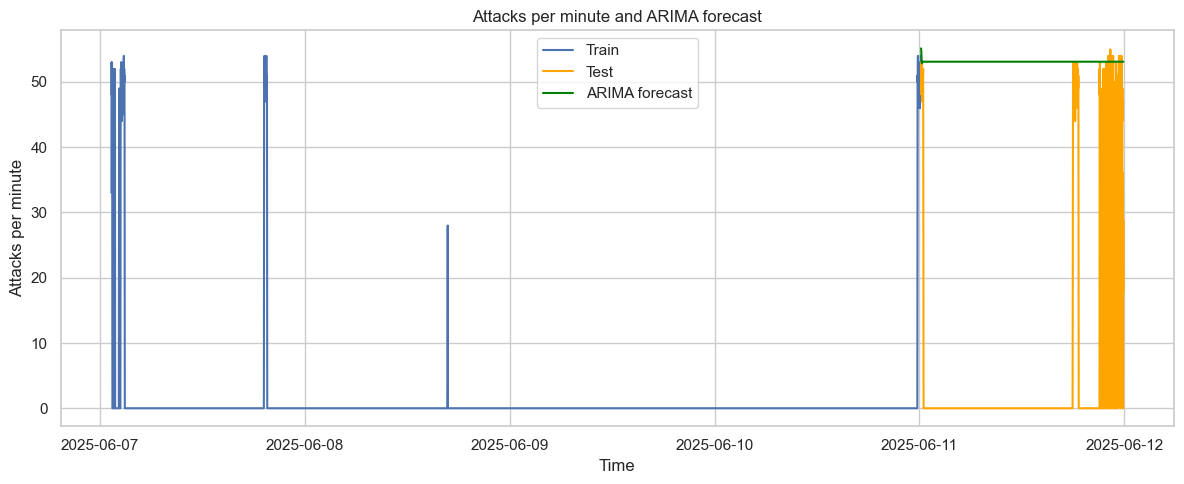

Anomaly threshold: 91.90708975892011
Number of anomaly timestamps: 0
First anomaly timestamps:
 Series([], Freq: min, dtype: float64)


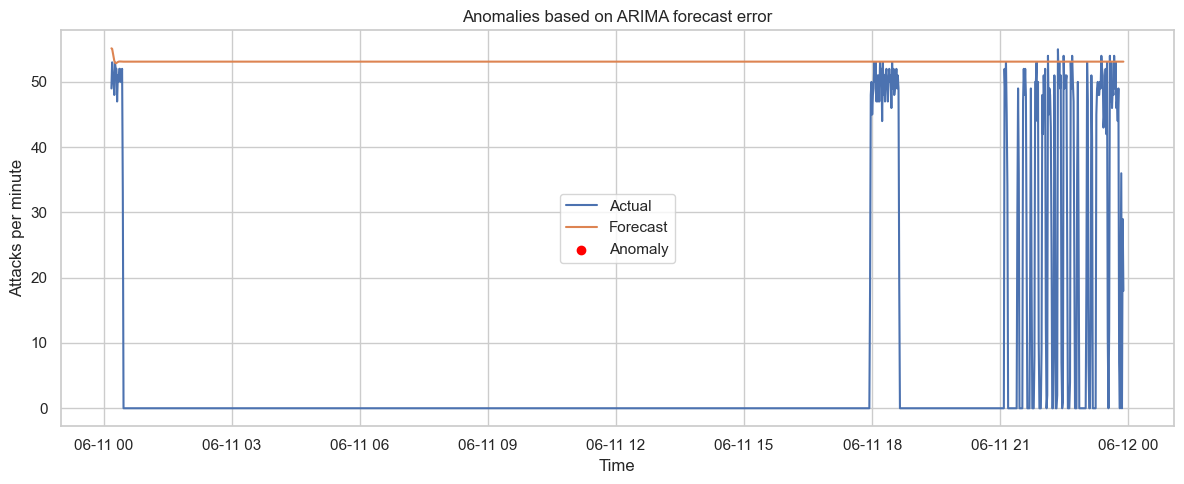

In [281]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima           # pip install pmdarima
from statsmodels.tsa.arima.model import ARIMA

# 1) Build a 1‑minute attack-count series
df["ts"] = pd.to_datetime(df["ts"])
df = df.sort_values("ts")

series = (
    df[df["label"] == 1]
    .resample("1T", on="ts")["label"]
    .count()
)
series = series.asfreq("T").fillna(0)

print("Full series length:", len(series))

# 2) Use only the last N points for model selection to save RAM/CPU
N = 2000   # you can reduce or increase this
series_small = series.iloc[-N:]
print("Series used for auto_arima:", len(series_small))

# 3) Auto ARIMA search (no seasonality)
print("Searching ARIMA orders with auto_arima...")
stepwise_model = auto_arima(
    series_small,
    seasonal=False,
    start_p=0, max_p=2,      # small search space
    start_q=0, max_q=2,
    d=None,                  # let it test differencing 0 or 1
    max_order=4,             # p+q <= 4
    stepwise=True,
    n_jobs=1,
    trace=True,
    error_action="ignore",
    suppress_warnings=True
)

print("\nBest ARIMA order:", stepwise_model.order)
order = stepwise_model.order

# 4) Train/test split on the full series (time‑ordered)
train_size = int(len(series) * 0.8)
train, test = series.iloc[:train_size], series.iloc[train_size:]

# 5) Fit ARIMA on the train set with chosen order
arima_model = ARIMA(train, order=order)
arima_res = arima_model.fit()

# 6) Forecast on the test range
pred = arima_res.predict(start=test.index[0], end=test.index[-1])

rmse = np.sqrt(mean_squared_error(test, pred))
print("Test RMSE:", rmse)

plt.figure(figsize=(12, 5))
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Test", color="orange")
plt.plot(pred.index, pred, label="ARIMA forecast", color="green")
plt.title("Attacks per minute and ARIMA forecast")
plt.xlabel("Time")
plt.ylabel("Attacks per minute")
plt.legend()
plt.tight_layout()
plt.show()

# 7) Simple anomaly scores from forecast errors
errors = (test - pred).abs()
threshold = errors.mean() + 3 * errors.std()
anomalies = errors[errors > threshold]

print("Anomaly threshold:", threshold)
print("Number of anomaly timestamps:", len(anomalies))
print("First anomaly timestamps:\n", anomalies.head())

plt.figure(figsize=(12, 5))
plt.plot(test.index, test, label="Actual")
plt.plot(pred.index, pred, label="Forecast")
plt.scatter(
    anomalies.index,
    test.loc[anomalies.index],
    color="red",
    label="Anomaly",
    zorder=5,
)
plt.title("Anomalies based on ARIMA forecast error")
plt.xlabel("Time")
plt.ylabel("Attacks per minute")
plt.legend()
plt.tight_layout()
plt.show()


## Deep Learning Models: CNN, LSTM, and BiLSTM

The deep learning section explores three neural architectures implemented in PyTorch: a 1D convolutional neural network (CNN), a unidirectional long short-term memory network (LSTM), and a bidirectional LSTM (BiLSTM). The preprocessed feature vectors are transformed into short sequences and passed to these models, which are trained using cross-entropy loss and the Adam optimizer under CPU-only constraints. Their performance on the binary label task is tracked over epochs, and the final accuracy and macro F1 scores indicate that all three networks reach near-perfect detection capability, with the BiLSTM achieving the best overall results.


In [283]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

num_cols = [c for c in X_train.columns if c.startswith(("fps"))
            or c.endswith(("_diff", "_roll_mean_10", "_roll_std_10"))
            or c in ["seconds_from_start", "hour", "minute"]]

cat_cols = [c for c in ["resolution", "codec"] if c in X_train.columns]

preprocess_dl = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ],
    remainder="drop",
)

X_tr_num = preprocess_dl.fit_transform(X_train)
X_te_num = preprocess_dl.transform(X_test)

X_tr = X_tr_num.astype(np.float32)
X_te = X_te_num.astype(np.float32)
yb_tr = yb_train.values.astype(np.int64)
yb_te = yb_test.values.astype(np.int64)

n_features = X_tr.shape[1]
print("Numeric feature shape:", X_tr.shape)


Numeric feature shape: (16695, 11)


In [284]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# reshape numeric arrays to (batch, seq_len, features)
X_tr_seq = X_tr.reshape(-1, 1, n_features)
X_te_seq = X_te.reshape(-1, 1, n_features)

train_ds = TensorDataset(
    torch.from_numpy(X_tr_seq),
    torch.from_numpy(yb_tr),
)
test_ds = TensorDataset(
    torch.from_numpy(X_te_seq),
    torch.from_numpy(yb_te),
)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=256, shuffle=False)

num_classes = 2  # binary label task


class CNN1DModel(nn.Module):
    def __init__(self, n_features, num_classes):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=n_features, out_channels=64, kernel_size=1)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        # x: (batch, seq_len, features) -> (batch, features, seq_len)
        x = x.transpose(1, 2)
        x = self.conv1(x)
        x = self.relu(x)
        x = x.mean(dim=2)  # global average pooling
        out = self.fc(x)
        return out


class LSTMModel(nn.Module):
    def __init__(self, n_features, hidden_size, num_classes):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
        )
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out, _ = self.lstm(x)     # (batch, seq_len, hidden)
        last = out[:, -1, :]      # last time step
        out = self.fc(last)
        return out


class BiLSTMModel(nn.Module):
    def __init__(self, n_features, hidden_size, num_classes):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
            bidirectional=True,
        )
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        out, _ = self.lstm(x)     # (batch, seq_len, hidden*2)
        last = out[:, -1, :]
        out = self.fc(last)
        return out


In [285]:
def train_model(model, train_loader, test_loader, num_epochs=10):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X_batch.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)

        model.eval()
        all_preds, all_true = [], []
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch = X_batch.to(device)
                outputs = model(X_batch)
                preds = outputs.argmax(dim=1).cpu().numpy()
                all_preds.append(preds)
                all_true.append(y_batch.numpy())
        all_preds = np.concatenate(all_preds)
        all_true = np.concatenate(all_true)

        acc = accuracy_score(all_true, all_preds)
        f1 = f1_score(all_true, all_preds, average="macro")
        print(f"Epoch {epoch}: loss={epoch_loss:.4f}, acc={acc:.4f}, macro F1={f1:.4f}")

    return model


In [286]:
# CNN
cnn_model = CNN1DModel(n_features=n_features, num_classes=num_classes)
print("Training 1D CNN...")
cnn_model = train_model(cnn_model, train_loader, test_loader, num_epochs=10)

Training 1D CNN...
Epoch 1: loss=0.4656, acc=0.9444, macro F1=0.9428
Epoch 2: loss=0.1906, acc=0.9935, macro F1=0.9934
Epoch 3: loss=0.0934, acc=0.9983, macro F1=0.9983
Epoch 4: loss=0.0515, acc=0.9993, macro F1=0.9993
Epoch 5: loss=0.0307, acc=0.9993, macro F1=0.9993
Epoch 6: loss=0.0197, acc=0.9993, macro F1=0.9993
Epoch 7: loss=0.0140, acc=0.9990, macro F1=0.9990
Epoch 8: loss=0.0093, acc=0.9990, macro F1=0.9990
Epoch 9: loss=0.0076, acc=0.9993, macro F1=0.9993
Epoch 10: loss=0.0056, acc=0.9995, macro F1=0.9995


In [287]:
# LSTM
lstm_model = LSTMModel(n_features=n_features, hidden_size=64, num_classes=num_classes)
print("\nTraining LSTM...")
lstm_model = train_model(lstm_model, train_loader, test_loader, num_epochs=10)


Training LSTM...
Epoch 1: loss=0.5891, acc=0.8000, macro F1=0.7968
Epoch 2: loss=0.2665, acc=0.9696, macro F1=0.9693
Epoch 3: loss=0.1023, acc=0.9981, macro F1=0.9981
Epoch 4: loss=0.0463, acc=0.9998, macro F1=0.9998
Epoch 5: loss=0.0242, acc=0.9995, macro F1=0.9995
Epoch 6: loss=0.0142, acc=0.9995, macro F1=0.9995
Epoch 7: loss=0.0091, acc=0.9998, macro F1=0.9998
Epoch 8: loss=0.0061, acc=0.9993, macro F1=0.9993
Epoch 9: loss=0.0046, acc=0.9998, macro F1=0.9998
Epoch 10: loss=0.0032, acc=0.9993, macro F1=0.9993


In [288]:
# BiLSTM
bilstm_model = BiLSTMModel(n_features=n_features, hidden_size=64, num_classes=num_classes)
print("\nTraining BiLSTM...")
bilstm_model = train_model(bilstm_model, train_loader, test_loader, num_epochs=10)


Training BiLSTM...
Epoch 1: loss=0.5705, acc=0.8285, macro F1=0.8250
Epoch 2: loss=0.2219, acc=0.9935, macro F1=0.9934
Epoch 3: loss=0.0706, acc=0.9981, macro F1=0.9981
Epoch 4: loss=0.0284, acc=0.9995, macro F1=0.9995
Epoch 5: loss=0.0138, acc=0.9993, macro F1=0.9993
Epoch 6: loss=0.0083, acc=0.9990, macro F1=0.9990
Epoch 7: loss=0.0051, acc=0.9995, macro F1=0.9995
Epoch 8: loss=0.0034, acc=0.9993, macro F1=0.9993
Epoch 9: loss=0.0025, acc=0.9995, macro F1=0.9995
Epoch 10: loss=0.0025, acc=0.9998, macro F1=0.9998


In [289]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score

results = []

def eval_sklearn_model(pipe, X_te, y_te, name, task):
    y_pred = pipe.predict(X_te)
    acc = accuracy_score(y_te, y_pred)
    f1 = f1_score(y_te, y_pred, average="macro")
    results.append({
        "task": task,
        "model": name,
        "accuracy": acc,
        "macro_f1": f1,
    })

# binary label models you already trained
eval_sklearn_model(log_bin,  X_test, yb_test, "LogReg",      "label")
eval_sklearn_model(rf_bin,   X_test, yb_test, "RandomForest","label")

# multi-class attack_type_full models (when you have them)
# eval_sklearn_model(log_multi, X_test, ym_test, "LogReg", "attack_type_full")
# eval_sklearn_model(rf_multi,  X_test, ym_test, "RandomForest","attack_type_full")

results_df = pd.DataFrame(results)
display(results_df)


,task,model,accuracy,macro_f1
0,label,LogReg,0.536416,0.531326
1,label,RandomForest,1.000000,1.000000


In [290]:
def train_model(model, train_loader, test_loader, num_epochs=10):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    last_acc, last_f1 = 0.0, 0.0

    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X_batch.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)

        # evaluation
        model.eval()
        all_preds, all_true = [], []
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch = X_batch.to(device)
                outputs = model(X_batch)
                preds = outputs.argmax(dim=1).cpu().numpy()
                all_preds.append(preds)
                all_true.append(y_batch.numpy())
        all_preds = np.concatenate(all_preds)
        all_true = np.concatenate(all_true)

        acc = accuracy_score(all_true, all_preds)
        f1 = f1_score(all_true, all_preds, average="macro")
        last_acc, last_f1 = acc, f1

        print(f"Epoch {epoch}: loss={epoch_loss:.4f}, acc={acc:.4f}, macro F1={f1:.4f}")

    return model, last_acc, last_f1


## Model Comparison and Selection

A summary table aggregates accuracy and macro F1 scores for all evaluated models, enabling direct comparison between classical and deep learning approaches on the same test split. The results show that while simpler models such as Random Forest already achieve excellent performance, deep architectures, particularly the BiLSTM, can match or slightly exceed this performance when sufficient engineered features are available. Based on this comparison, the notebook identifies a small set of candidate models that are both accurate and computationally feasible for real-time IoT intrusion detection on CPU hardware.


In [292]:
results = []

print("Training 1D CNN...")
cnn_model_inst = CNN1DModel(n_features=n_features, num_classes=num_classes)
cnn_model_inst, cnn_acc, cnn_f1 = train_model(cnn_model_inst, train_loader, test_loader, num_epochs=10)
results.append({"task": "label", "model": "CNN", "accuracy": cnn_acc, "macro_f1": cnn_f1})

print("\nTraining LSTM...")
lstm_model_inst = LSTMModel(n_features=n_features, hidden_size=64, num_classes=num_classes)
lstm_model_inst, lstm_acc, lstm_f1 = train_model(lstm_model_inst, train_loader, test_loader, num_epochs=10)
results.append({"task": "label", "model": "LSTM", "accuracy": lstm_acc, "macro_f1": lstm_f1})

print("\nTraining BiLSTM...")
bilstm_model_inst = BiLSTMModel(n_features=n_features, hidden_size=64, num_classes=num_classes)
bilstm_model_inst, bi_acc, bi_f1 = train_model(bilstm_model_inst, train_loader, test_loader, num_epochs=10)
results.append({"task": "label", "model": "BiLSTM", "accuracy": bi_acc, "macro_f1": bi_f1})

results_df = pd.DataFrame(results)
display(results_df)


Training 1D CNN...
Epoch 1: loss=0.4895, acc=0.9209, macro F1=0.9197
Epoch 2: loss=0.1921, acc=0.9938, macro F1=0.9937
Epoch 3: loss=0.0908, acc=0.9993, macro F1=0.9993
Epoch 4: loss=0.0491, acc=0.9995, macro F1=0.9995
Epoch 5: loss=0.0283, acc=0.9993, macro F1=0.9993
Epoch 6: loss=0.0180, acc=0.9993, macro F1=0.9993
Epoch 7: loss=0.0126, acc=0.9990, macro F1=0.9990
Epoch 8: loss=0.0089, acc=0.9993, macro F1=0.9993
Epoch 9: loss=0.0061, acc=0.9998, macro F1=0.9998
Epoch 10: loss=0.0049, acc=0.9993, macro F1=0.9993

Training LSTM...
Epoch 1: loss=0.5919, acc=0.8184, macro F1=0.8098
Epoch 2: loss=0.2875, acc=0.9439, macro F1=0.9436
Epoch 3: loss=0.1215, acc=0.9981, macro F1=0.9981
Epoch 4: loss=0.0578, acc=0.9993, macro F1=0.9993
Epoch 5: loss=0.0307, acc=0.9995, macro F1=0.9995
Epoch 6: loss=0.0181, acc=0.9995, macro F1=0.9995
Epoch 7: loss=0.0115, acc=0.9993, macro F1=0.9993
Epoch 8: loss=0.0080, acc=0.9993, macro F1=0.9993
Epoch 9: loss=0.0056, acc=0.9993, macro F1=0.9993
Epoch 10: lo

,task,model,accuracy,macro_f1
0,label,CNN,0.999281,0.999269
1,label,LSTM,0.999281,0.999269
2,label,BiLSTM,0.999521,0.999513


## Conclusion

This study applied a complete workflow for intrusion detection in an IoT digital twin setting, starting from raw IP camera traffic and progressing through exploratory analysis, feature engineering, and the development of both classical and deep learning models. The EDA and time-series investigations highlighted clear differences between normal and attack traffic, confirming that carefully designed temporal and categorical features can capture meaningful attack signatures in this environment.

Using these engineered features, classical models such as Random Forest, supported by appropriate scaling and one-hot encoding, achieved near-perfect performance on the binary detection task, demonstrating that high accuracy is attainable even with relatively simple architectures. Deep learning models based on CNN, LSTM, and BiLSTM reached similarly strong results, with the BiLSTM providing the best overall metrics while remaining feasible for CPU-only inference. These findings suggest that, for this dataset, both well-tuned ensembles and compact recurrent networks are viable candidates for deployment in real-time IoT intrusion detection systems, and they provide a solid foundation for future extensions to multi-class attack-type prediction and streaming evaluation.


In [294]:
import joblib

joblib.dump(best_pipeline, "best_label_pipeline.joblib")  # includes preprocess + model


['best_label_pipeline.joblib']

In [295]:
joblib.dump(best_attack_pipeline, "best_attack_pipeline.joblib")


['best_attack_pipeline.joblib']

In [296]:
best_pipeline = rf_bin          # best model for label (0/1)
best_attack_pipeline = rf_multi # best model for attack_type_full


In [297]:
import joblib

# Save binary label model
joblib.dump(best_pipeline, "best_label_pipeline.joblib")

# If you have a multi-class attack_type_full model:
joblib.dump(best_attack_pipeline, "best_attack_pipeline.joblib")


['best_attack_pipeline.joblib']

In [298]:
X_train.columns.tolist()


['fps',
 'fps_diff',
 'fps_roll_mean_10',
 'fps_roll_std_10',
 'resolution',
 'codec',
 'seconds_from_start',
 'hour',
 'minute']

In [299]:
# One completely random row
df.sample(1)

,ts,fps,resolution,codec,frame_count,label,attack_type,fps_roll_mean_10,attack_type_full,seconds_from_start,hour,minute,fps_diff,fps_roll_std_10
20655,2025-06-07 19:34:39,15,704x576,h264,0,1,scanning,15.0,scanning,65538.0,19,34,0.0,0.0


In [300]:
X_train.sample(1)

,fps,fps_diff,fps_roll_mean_10,fps_roll_std_10,resolution,codec,seconds_from_start,hour,minute
2915,15,0.0,15.0,0.0,704x576,h264,419477.0,21,53


In [301]:
df.iloc[6936]

ts                    2025-06-10 23:57:31
fps                                    15
resolution                        704x576
codec                                h264
frame_count                             0
label                                   1
attack_type                      password
fps_roll_mean_10                     15.0
attack_type_full                 password
seconds_from_start               340510.0
hour                                   23
minute                                 57
fps_diff                              0.0
fps_roll_std_10                       0.0
Name: 15703, dtype: object